In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
PRISM_PATH = "/Users/andreapf/postdoc/prism-games-3.2.1-mac64-arm/bin/prism" # path to PRISM-games install
STRATEGY_PATH = ".../adv.tra" # path to where strategies shall be stored
STORE_PATH = "..." # path to where generated models can be stored
QUERY_PATH = ".../queries/" # path to queries
OUTPUT_PATH = ".../outputs/" # path to PRISM-games generated output files

In [3]:
from journepy.src.preprocessing.greps import preprocessed_log
from journepy.src.alergia_utils import convert_utils
from journepy.src.mc_utils.prism_utils import PrismPrinter
from journepy.src.mc_utils.prism_utils import PrismQuery

import probabilistic_game_utils as pgu 

from aalpy.learning_algs import run_Alergia
from aalpy.utils import save_automaton_to_file
from IPython.display import Image


import pandas as pd
import matplotlib.pyplot as plt

from networkx.drawing.nx_agraph import to_agraph

import json

import networkx as nx

import subprocess

import matplotlib.pyplot as plt

# Load Data
We load the event log and additionally needed information.

In [4]:
filtered_log = preprocessed_log("data/data.csv", include_loggin=False) # also discards task-event log-in

Found types {'task', 'subject', 'latency', 'resultsShared', 'score', 'state', 'vpcInstance', 'feedback', 'activate'}
Includes #unsuccesfull: 16 and #succesfull 17
Variants before removing trivial elements
13


/home/paul/Documents/probabilistic_games/journepy/src/preprocessing/greps.py:71: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(path, sep = None) # infers delimiter automatically
/home/paul/Documents/probabilistic_games/journepy/src/preprocessing/greps.py:36: FutureWarning: The default value of regex will change from True to False in a future version.
  running_df['concept:name'] = running_df['concept:name'].str.replace(r"loggedIn.*","loggedIn") # removes feedback attributes
/home/paul/Documents/probabilistic_games/journepy/src/preprocessing/greps.py:37: FutureWarning: The default value of regex will change from True to False in a future version.
  running_df['concept:name'] = running_df['concept:name'].str.replace(r"\[.*\]","") # removes feedback attributes


In [5]:
# load actor mapping: maps events to an actor (service provider or user)
with open('data/activities_greps.xml') as f:
    data = f.read()
actors = json.loads(data)

In [6]:
# build action mapping: assigns each event to an actor
actions_to_activities = {}
for a in actors:
    if actors[a] == "company":
        if a in ['vpcAssignInstance', 'Give feedback 0', 'Results automatically shared', 'waitingForActivityReport']: # todo: might be quite realistic?
            actions_to_activities[a] = "company"
        else:  
            actions_to_activities[a] = a
    else:
        if a == "negative":
            actions_to_activities[a] = "user"
        elif "Give feedback" in a or "Task event" in a:
            actions_to_activities[a] = a
        else:
            actions_to_activities[a] = "user"
print(actions_to_activities) 

{'Results automatically shared': 'company', 'Results shared': 'user', 'waitingForSubjectAcceptance': 'user', 'readyToStart': 'readyToStart', 'Give feedback 0': 'company', 'Give feedback 1': 'Give feedback 1', 'Give feedback 2': 'Give feedback 2', 'Give feedback 3': 'Give feedback 3', 'Give feedback 4': 'Give feedback 4', 'Give feedback 5': 'Give feedback 5', 'waitingForManualScores': 'waitingForManualScores', 'activated': 'activated', 'positive': 'positive', 'negative': 'user', 'vpcCreateUserOnInstance': 'vpcCreateUserOnInstance', 'registered': 'user', 'Logged in: Web page': 'Logged in: Web page', 'started': 'started', 'start': 'start', 'subjectAcceptanceReceived': 'user', 'Task event: 0': 'Task event: 0', 'Task event: 1': 'Task event: 1', 'Task event: 2': 'Task event: 2', 'Task event: 3': 'Task event: 3', 'Task event: 4': 'Task event: 4', 'Task event: 5': 'Task event: 5', 'waitingForResultApproval': 'waitingForResultApproval', 'finished': 'finished', 'waitingForScores': 'waitingForSco

## Passive automata learning
The event log is transformed into an Input/Output format and environment actions to select the next player are added additionally.
Alergia learning automatically selects IO/Alergia if input is in [O, (I,O), ...] format.

In [7]:
# change from xes format
filtered_log_activities = [[e['concept:name'] for e in t] for t in filtered_log]

In [8]:
data = [[(actions_to_activities[t[i]], t[i]) for i in range(1, len(t))] for t in filtered_log_activities]
for d in data:
    d.insert(0, 'start')

In [9]:
model = run_Alergia(data, automaton_type='mdp', eps=0.9, print_info=True)

PTA Construction Time:  0.0
Alergia Learning Time: 0.0
Alergia Learned 29 state automaton.


In [10]:
filename = "greps/greps-example_2"
save_automaton_to_file(model, f"{filename}.dot")
save_automaton_to_file(model, f"{filename}.png", file_type="png")

Model saved to greps/greps-example_2.dot.


Model saved to greps/greps-example_2.png.


Model contains some inconsistencies, e.g. repeating the same test, i.e. test 4 (give feedback 4).

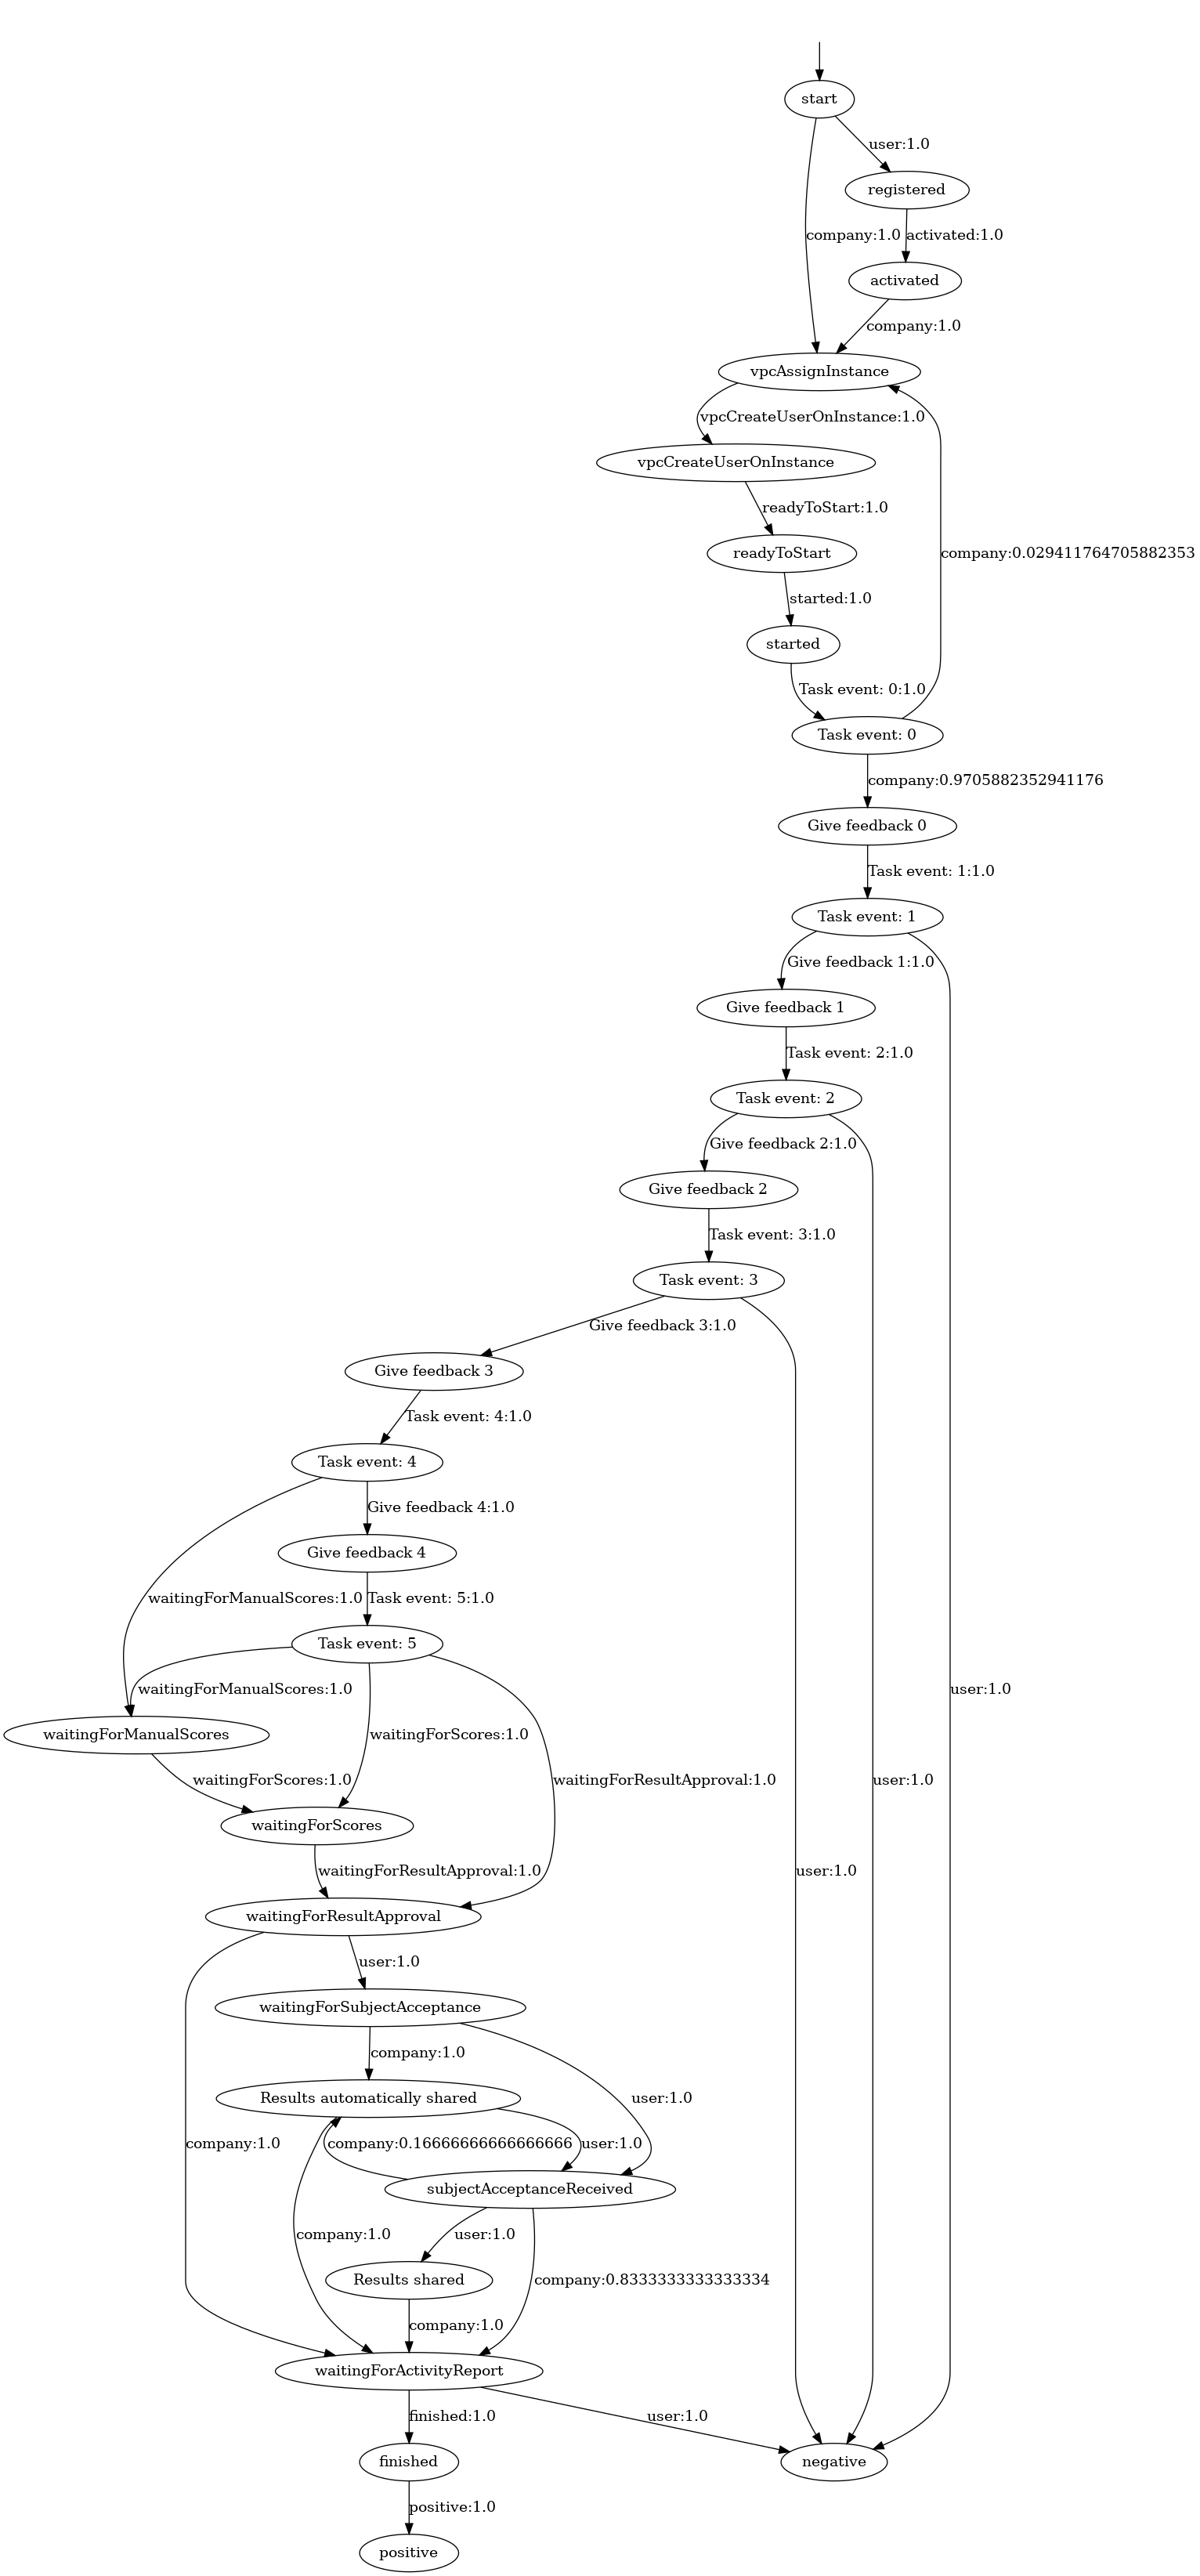

In [11]:
Image(f"{filename}.png")

In [12]:
# quantify environment - distribution of players after for events is learned
data_environment = []
for trace in data:
    current = [trace[0]]
    for i in range(1, len(trace)):
        e = trace[i]
        previous_state = "start" if i == 1 else trace[i-1][1]
        
        # encode decision in one step
        current.append(('env', actors[e[1]] + previous_state))
        current.append(e)
    data_environment.append(current)

In [13]:
model_environment = run_Alergia(data_environment, automaton_type='mdp', eps=0.1, print_info=True)

PTA Construction Time:  0.0
Alergia Learning Time: 0.02
Alergia Learned 65 state automaton.


In [14]:
filename = "greps/greps-example_environment_actions"
save_automaton_to_file(model_environment, f"{filename}.dot")
save_automaton_to_file(model_environment, f"{filename}.png", file_type="png")

Model saved to greps/greps-example_environment_actions.dot.


Model saved to greps/greps-example_environment_actions.png.


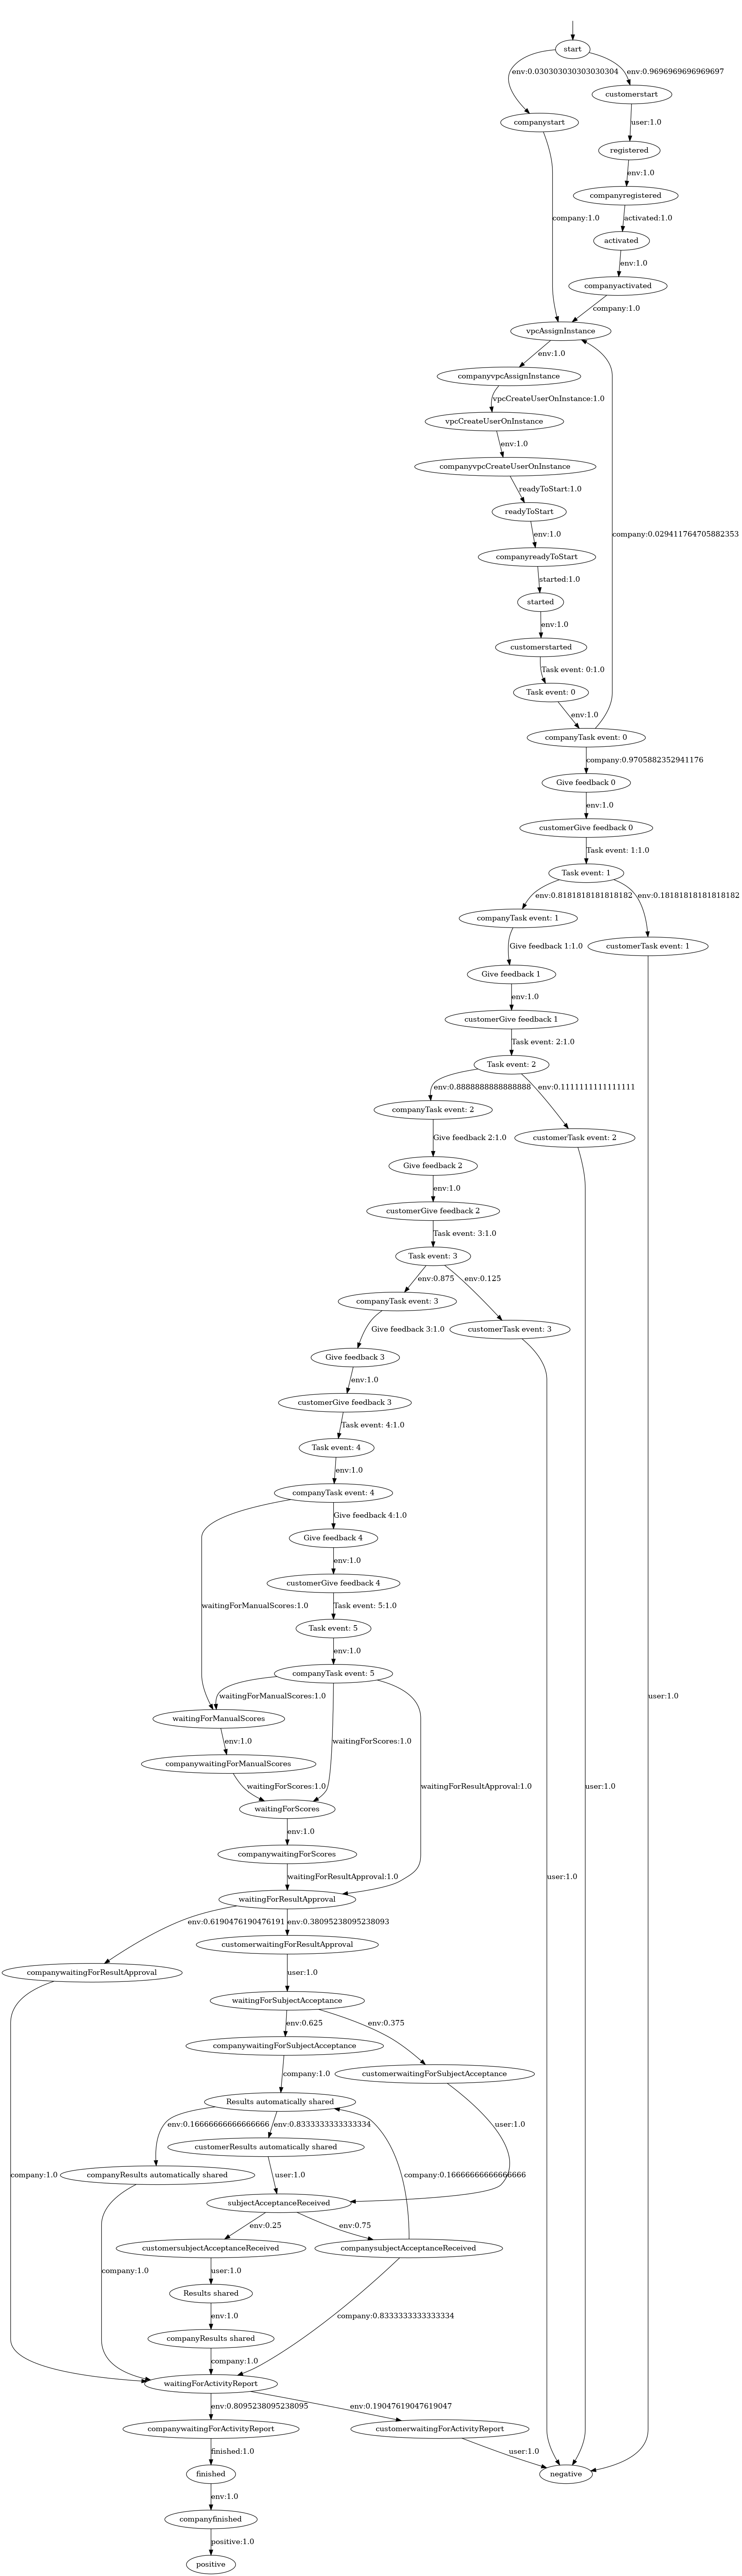

In [15]:
Image(f"{filename}.png")

## Convert MDP to Game in Networkx format

In [16]:
g = convert_utils.mdp_to_nx(model_environment, actors)

In [17]:
# users can decide to "do nothing"
g = pgu.add_neutral_user_transition(g)

current state q2: customerstart
in_e ('q0: start', 'q2: customerstart')
current state q14: customerstarted
in_e ('q13: started', 'q14: customerstarted')
current state q18: customerGive feedback 0
in_e ('q17: Give feedback 0', 'q18: customerGive feedback 0')
current state q25: customerTask event: 1
in_e ('q19: Task event: 1', 'q25: customerTask event: 1')
current state q22: customerGive feedback 1
in_e ('q21: Give feedback 1', 'q22: customerGive feedback 1')
current state q24: customerTask event: 2
in_e ('q23: Task event: 2', 'q24: customerTask event: 2')
current state q29: customerGive feedback 2
in_e ('q28: Give feedback 2', 'q29: customerGive feedback 2')
current state q32: customerTask event: 3
in_e ('q30: Task event: 3', 'q32: customerTask event: 3')
current state q34: customerGive feedback 3
in_e ('q33: Give feedback 3', 'q34: customerGive feedback 3')
current state q39: customerGive feedback 4
in_e ('q37: Give feedback 4', 'q39: customerGive feedback 4')
current state q46: custom

In [18]:
g = pgu.add_gas_and_user_count(g, data_environment, greps_values=True)

In [19]:
# Asserts that no deterministic cycle is contained anymore
def assert_no_det_cycle(g):
    for c in list(nx.simple_cycles(g)):
        found = False
        for i in range(len(c)):
            if g[c[i]][c[(i+1)%len(c)]]['prob_weight'] != 1:
                found = True
        assert found
assert_no_det_cycle(g)

# Model Checking Stochastic User Journey Games
The games are written to the prism format and PRISM-games is called.

In [20]:
printer = PrismPrinter(g, STORE_PATH, "alergia_reduction_model.prism")
printer.write_to_prism()

In [21]:
query = PrismQuery(g, STORE_PATH, "alergia_reduction_model.prism", PRISM_PATH)
# Query Q1 from Table 1
results_file = query.query(QUERY_PATH+"pos_alergia.props", write_parameterized=True)
print(results_file['q0start'])

0.5151507891233683


In [22]:
# Query Q2, Q3, and Q4 from Table 1
subprocess.run([PRISM_PATH, STORE_PATH+"alergia_reduction_model.prism", QUERY_PATH+"mc_runs.props", "-const", "envprob=0"]) 

PRISM-games

Version: 3.2.1 (based on PRISM 4.8.dev)
Date: Tue Apr 30 10:17:51 CEST 2024
Hostname: hp
Memory limits: cudd=1g, java(heap)=1g
Command line: prism-games /home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/alergia_reduction_model.prism /home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/mc_runs.props -const envprob=0

Parsing model file "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/alergia_reduction_model.prism"...

Type:        SMG
Modules:     userModule providerModule controll
Variables:   gas state negative positive final_gas steps min_gas

Parsing properties file "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/mc_runs.props"...

3 properties:
(1) <<providerPlayer,userPlayer>>R{"gas_neg"}min=? [ F (positive|negative) ]
(2) <<providerPlayer>>R{"gas_neg"}min=? [ F (positive|negative) ]
(3) <<providerPlayer>>R{"gas_pos"}max=? [ F (positive|negative) ]

----------------------------------------------------------

CompletedProcess(args=['/home/paul/Downloads/prism-games-3.2.1-linux64-x86/bin/prism', '/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/alergia_reduction_model.prism', '/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/mc_runs.props', '-const', 'envprob=0'], returncode=0)

In [23]:
# run Activity experiment
# remove "stdout=subprocess.DEVNULL" to print output again
file_name = OUTPUT_PATH+"succ_prop_cond.txt"
subprocess.run([PRISM_PATH, STORE_PATH+"alergia_reduction_model.prism", 
                QUERY_PATH+"pos_alergia.props", 
                "-const", "envprob=-0.95:0.05:0.95", "-exportresults", file_name+":dataframe"], stdout=subprocess.DEVNULL) 

CompletedProcess(args=['/home/paul/Downloads/prism-games-3.2.1-linux64-x86/bin/prism', '/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/alergia_reduction_model.prism', '/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/pos_alergia.props', '-const', 'envprob=-0.95:0.05:0.95', '-exportresults', '/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/outputs/succ_prop_cond.txt:dataframe'], returncode=0)

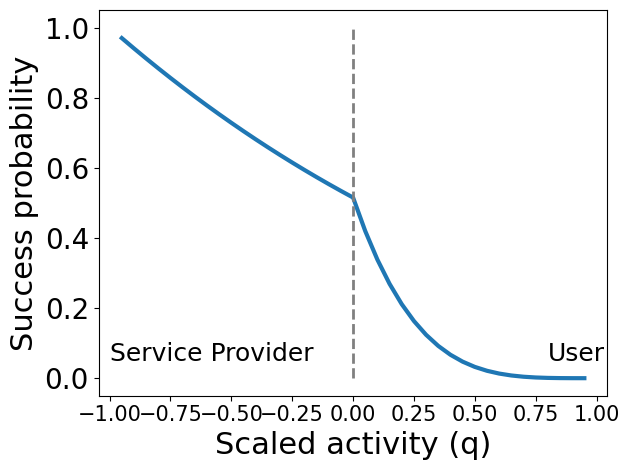

In [24]:
# produces Fig. 1a
df_visual = pd.read_csv(file_name)
plt.plot(df_visual['envprob'], df_visual['Result'],linewidth=3)
plt.vlines(x=0, ymin=0, ymax = 1, linewidth=2, color = 'grey', linestyles='--')
plt.text(-1, 0.05, 'Service Provider', fontsize = 18)
plt.text(0.8, 0.05, 'User', fontsize = 18)
plt.xlabel("Scaled activity (q)", fontsize=22)
plt.ylabel("Success probability", fontsize=22)
plt.xticks(fontsize=15)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.savefig("greps/greps_activity_comparison.png", dpi=300)
plt.show()

In [25]:
# run gas upper and lower bound under limited steps
PrismPrinter(g, STORE_PATH, "alergia_reduction_model.prism").write_to_prism(write_extended_parameterized=True)
file_name = OUTPUT_PATH+"steps_gas_pos_bound.txt"
subprocess.run([PRISM_PATH, STORE_PATH+"alergia_reduction_model.prism", 
                QUERY_PATH+"reward_props.props", "-prop", "3",
                "-const", "m0=0,m1=0:1:140,m2=0,", "-exportresults", file_name+":dataframe"], stdout=subprocess.DEVNULL) 
file_name = OUTPUT_PATH+"steps_gas_neg_bound.txt"
subprocess.run([PRISM_PATH, STORE_PATH+"alergia_reduction_model.prism", 
                QUERY_PATH+"reward_props.props", "-prop", "4",
                "-const", "m0=0,m1=0:1:140,m2=0,", "-exportresults", file_name+":dataframe"], stdout=subprocess.DEVNULL) 

CompletedProcess(args=['/home/paul/Downloads/prism-games-3.2.1-linux64-x86/bin/prism', '/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/alergia_reduction_model.prism', '/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/reward_props.props', '-prop', '4', '-const', 'm0=0,m1=0:1:140,m2=0,', '-exportresults', '/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/outputs/steps_gas_neg_bound.txt:dataframe'], returncode=0)

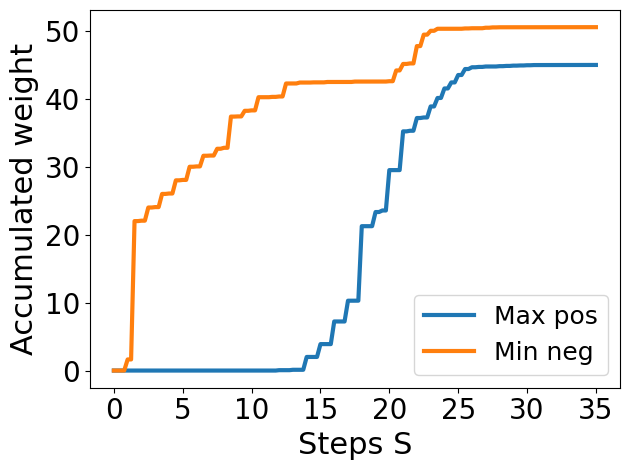

In [26]:
# produces Fig. 1b
file_name = OUTPUT_PATH+"steps_gas_pos_bound.txt"
df_visual = pd.read_csv(file_name)
plt.plot(df_visual['m1']/4, df_visual['Result'], label="Max pos", linewidth = 3)
file_name = OUTPUT_PATH+"steps_gas_neg_bound.txt"
df_visual = pd.read_csv(file_name)
plt.plot(df_visual['m1']/4, df_visual['Result'], label="Min neg", linewidth = 3)
# divide by 4 to account for (1) env action and (2) dummy actions to calculate rewards

plt.legend(fontsize=18)
plt.xlabel("Steps S", fontsize=22)
plt.ylabel("Accumulated weight", fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.savefig("greps/gas_steps.png", dpi=300)
plt.show()

## Induced and Reduced Model
We generate a strategy for Q1 and build the induced Markov chain. 

In [27]:
query = PrismQuery(g, STORE_PATH, "alergia_reduction_model.prism", PRISM_PATH)
strategy = query.get_strategy(QUERY_PATH+"pos_alergia.props")

skipped ['q37Givefeedback4']
skipped ['q39customerGivefeedback4']
skipped ['q41Taskevent5']
skipped ['q43companyTaskevent5']
skipped ['q62Resultsshared']
skipped ['q63companyResultsshared']


In [28]:
def can_be_merged(g, results_file):
    for s in g.nodes():
        reachable_values = [round(results_file[t],2) for t in g[s]]
        if round(results_file[s],2) in reachable_values:
            return s 
    return None

"""
NOTE: One positive and one negative node is kept and all remaining from positive/negative cluster are merged into them.
"""
def reduce_graph(g, results_file):
    neg_cluster = []
    pos_cluster = []
    print("size start", len(g.nodes()))
    s = can_be_merged(g, results_file)
    while(s != None):
        for t in g[s]:
            if round(results_file[t],2) != round(results_file[s],2):
                continue
            g = nx.contracted_nodes(g, s, t, self_loops = False)
        s = can_be_merged(g, results_file)

    for s in g:
        if results_file[s] == 0:
            neg_cluster.append(s)
        if results_file[s] == 1:
            pos_cluster.append(s)
    for s in pos_cluster[1:]:
        g = nx.contracted_nodes(g, pos_cluster[0], s, self_loops=False)
    for s in neg_cluster[1:]:
        g = nx.contracted_nodes(g, neg_cluster[0], s, self_loops=False)



    g.remove_edges_from(nx.selfloop_edges(g))

    print("size reduced", len(g.nodes()))
    return g

In [29]:
from  matplotlib.colors import LinearSegmentedColormap # for color map
from matplotlib.colors import rgb2hex

def compute_color_map(g, results_file):
    c = ["darkred","gold","darkgreen"]
    v = [0,0.5,1]
    l = list(zip(v,c))
    cmap=LinearSegmentedColormap.from_list('rg',l, N=256)
    s = cmap(0.23)
    map = {}
    for s in g.nodes():
        map[s] = rgb2hex(cmap(results_file[s])) # have to convert to hex color
    return map

def draw_dfg(g, name, names={}, layout = "sfdp", color_map = []):
    """
    Helper function to draw Networkx graphs.
    """
    scaling = 10
    # build graph with variable thickness
    #scaling = 1/np.mean(list(nx.get_edge_attributes(g,'edge_weight').values()))

    A = to_agraph(g)

    edge_weights = nx.get_edge_attributes(g,'edge_weight')
    for e in edge_weights:
        e = A.get_edge(e[0], e[1])
        e.attr["penwidth"] = edge_weights[e]*scaling
        e.attr["fontsize"] = "20"
    for e in g.edges:
        edge = A.get_edge(e[0], e[1])
        if 'controllable' in g[e[0]][e[1]]:
            if not g[e[0]][e[1]]['controllable']:
                edge.attr["style"] = "dotted"
                #edge.attr["label"] =  str(g[e[0]][e[1]]["prob_weight"])
        #A.add_edge(e[0], e[1], penwidth = edge_weights[e]*scaling)

    for n in A.nodes():
        if n in names:
            new = names[n]
            if isinstance(names[n], float): 
                new = round(names[n], 2)
            n.attr['label'] = new
            #if new == 1:
            #    n.attr['label'] = "pos"
            #elif new == 0:
            #    n.attr['label'] = "neg"
            #else:
            #    n.attr["label"] = "" # uncomment to print state names
        if n in color_map:
            n.attr['color'] = color_map[n]
    
        n.attr['fontsize'] = 120
        n.attr['penwidth'] = 30
        n.attr['height'] = 3
        n.attr['width'] = 3

    for e in A.edges():
        e.attr['penwidth'] = 20
        e.attr["fontsize"] = 120
        e.attr["label"] = str(round(g[e[0]][e[1]]["prob_weight"],2))
        e.attr["color"] = "black"

        if g[e[0]][e[1]]['gas'] > 0:
            e.attr["color"] ="darkgreen"
        if g[e[0]][e[1]]['gas'] < 0:
            e.attr["color"] ="red"

    
    
    print(A.nodes())
    # Adding clusters for the GrepS phases
    onboarding = ["T"+str(i) for i in range(0,6)]
    onboarding = [n for n in A.nodes() if names[n] in onboarding]
    A.add_subgraph(onboarding, name='cluster_onboarding', label= "Sign-up", color = "orange", fontsize = 90, fontcolor = "orange", penwidth= 10)
    task = ["T"+str(i) for i in range(6,21)]
    task = [n for n in A.nodes() if names[n] in task]
    A.add_subgraph(task, name='cluster_task', label= "Solve tasks", color = "blue", fontsize = 90, fontcolor = "blue", penwidth= 10)
    evaluation = ["T"+str(i) for i in range(21,27)]
    evaluation = [n for n in A.nodes() if names[n] in evaluation]
    A.add_subgraph(evaluation, name='cluster_evaluation', label= "Review and share", color = "purple", fontsize = 90, fontcolor = "purple", penwidth= 10)
             
    A.write(name.split(".")[0]+".dot")
    A.layout(layout)
    A.draw(name)
    print("Plotted", name)

In [30]:
# Naming for Fig. 3
naming = {
    "registered" : "T0",
    "activated": "T1",
    #"Logged in: Web page - Sign up" : "T2",
    "vpcCreateUserOnInstance" : "T3",
    "vpcAssignInstance" : "T2",
    "readyToStart" : "T4",
    "Task event: loggedIn" : "T5",
    "started" : "T6",
    "Task event: 0": "T7",
    "Give feedback 0" : "T8",
    "Task event: 1": "T9",
    "Give feedback 1" : "T10",
    "Task event: 2": "T11",
    "Give feedback 2" : "T12",
    "Task event: 3": "T13",
    "Give feedback 3" : "T14",
    "Task event: 4": "T15",
    "Give feedback 4" : "T16",
    "Task event: 5": "T17",
    "waitingForManualScores" : "T18",
    "Logged in: Web page - Task" : "T19",
    "waitingForScores" : "T20",
    "waitingForResultApproval" : "T21",
    "waitingForSubjectAcceptance" : "T22",
    "subjectAcceptanceReceived" : "T23",
    "Results automatically shared" : "T24",
    "waitingForActivityReport" : "T25",
    "Results shared" : "T26",
    "Logged in: Web page - Approval" : "T26",
    "negative" : "unsucc",
    "positive" : "succ",
    "start": "s₀",
    "finished":"finished"
}

extended_naming = {}
for k in naming:
    extended_naming['customer'+k] = "U-"+naming[k]
    extended_naming['company'+k] = "C-"+naming[k]
    extended_naming[k] = naming[k]

extended_id_naming = {}
for k in g.nodes():
    name = ": ".join(k.split(": ")[1:])
    if name in extended_naming:
        assert name in extended_naming, name
        extended_id_naming[k] = extended_naming[name]
print(extended_id_naming)

#extended_naming = {'customer'+k : naming[k], 'company'+k : naming[k]  for k in naming}

{'q0: start': 's₀', 'q2: customerstart': 'U-s₀', 'q1: companystart': 'C-s₀', 'q3: vpcAssignInstance': 'T2', 'q4: registered': 'T0', 'q5: companyvpcAssignInstance': 'C-T2', 'q6: companyregistered': 'C-T0', 'q7: vpcCreateUserOnInstance': 'T3', 'q8: activated': 'T1', 'q9: companyvpcCreateUserOnInstance': 'C-T3', 'q10: companyactivated': 'C-T1', 'q11: readyToStart': 'T4', 'q12: companyreadyToStart': 'C-T4', 'q13: started': 'T6', 'q14: customerstarted': 'U-T6', 'q15: Task event: 0': 'T7', 'q16: companyTask event: 0': 'C-T7', 'q17: Give feedback 0': 'T8', 'q18: customerGive feedback 0': 'U-T8', 'q19: Task event: 1': 'T9', 'q20: companyTask event: 1': 'C-T9', 'q25: customerTask event: 1': 'U-T9', 'q21: Give feedback 1': 'T10', 'q22: customerGive feedback 1': 'U-T10', 'q23: Task event: 2': 'T11', 'q24: customerTask event: 2': 'U-T11', 'q27: companyTask event: 2': 'C-T11', 'q26: negative': 'unsucc', 'q28: Give feedback 2': 'T12', 'q29: customerGive feedback 2': 'U-T12', 'q30: Task event: 3': 'T

In [31]:
def get_probs_file(results_file, g, printer):
    isomorphism = nx.vf2pp_isomorphism(printer.g, g, node_label=None)
    parsed_results_file = {isomorphism[r] : results_file[r] for r in results_file}
    return parsed_results_file

color_map = compute_color_map(g, get_probs_file(results_file, g, printer))

import copy 
reduced_graph = copy.deepcopy(g)
for s in g:
    for t in g:
        if ("C-"+extended_id_naming[s] == extended_id_naming[t] or "U-"+extended_id_naming[s] == extended_id_naming[t]):
            reduced_graph = nx.contracted_nodes(reduced_graph, s, t, self_loops=False)

draw_dfg(reduced_graph, "greps/greps_clustered.png", names=extended_id_naming, layout = "dot", color_map=color_map)

['q0: start', 'q3: vpcAssignInstance', 'q4: registered', 'q7: vpcCreateUserOnInstance', 'q8: activated', 'q11: readyToStart', 'q13: started', 'q15: Task event: 0', 'q17: Give feedback 0', 'q19: Task event: 1', 'q21: Give feedback 1', 'q23: Task event: 2', 'q26: negative', 'q28: Give feedback 2', 'q30: Task event: 3', 'q33: Give feedback 3', 'q35: Task event: 4', 'q38: waitingForManualScores', 'q37: Give feedback 4', 'q41: Task event: 5', 'q42: waitingForScores', 'q45: waitingForResultApproval', 'q48: waitingForSubjectAcceptance', 'q49: waitingForActivityReport', 'q53: Results automatically shared', 'q54: finished', 'q57: subjectAcceptanceReceived', 'q58: positive', 'q62: Results shared']
Plotted greps/greps_clustered.png


In [32]:
# Produces Figure 3
import copy
def plot_reduction(g, name, results_file, layout = "sdf"):
    g = copy.deepcopy(g)
    g = reduce_graph(g, results_file)
    color_map = compute_color_map(g, results_file)
    draw_dfg(g, name, names = results_file, layout = layout, color_map=color_map)
plot_reduction(g, "greps/alergia_reduced.png", get_probs_file(results_file, g, printer), layout = "dot")

size start 65
size reduced 6
['q0: start', 'q20: companyTask event: 1', 'q27: companyTask event: 2', 'q31: companyTask event: 3', 'q52: customerwaitingForActivityReport', 'q51: companywaitingForActivityReport']
Plotted greps/alergia_reduced.png


### Constrained steps and parameterized transitions

In [33]:
# compute expected values for reward structures (Q7)
subprocess.run([PRISM_PATH, STORE_PATH+"alergia_reduction_model.prism", QUERY_PATH+"exp_values.props"]) 

PRISM-games

Version: 3.2.1 (based on PRISM 4.8.dev)
Date: Tue Apr 30 10:18:10 CEST 2024
Hostname: hp
Memory limits: cudd=1g, java(heap)=1g
Command line: prism-games /home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/alergia_reduction_model.prism /home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/exp_values.props

Parsing model file "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/alergia_reduction_model.prism"...

Type:        SMG
Modules:     userModule providerModule controll
Variables:   gas state negative positive final_gas steps min_gas

Parsing properties file "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/exp_values.props"...

3 properties:
(1) <<providerPlayer>>R{"steps"}max=? [ Fc positive ]
(2) <<providerPlayer>>R{"gas_neg"}max=? [ Fc positive ]
(3) <<providerPlayer>>R{"gas_pos"}max=? [ Fc positive ]

---------------------------------------------------------------------

Model checking: <<providerPlayer>>R{"step

CompletedProcess(args=['/home/paul/Downloads/prism-games-3.2.1-linux64-x86/bin/prism', '/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/alergia_reduction_model.prism', '/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/exp_values.props'], returncode=0)

In [34]:
steps_max = 20
max_gas = 45
min_gas= 16

In [35]:
# Query Q1 on bounded model
query = PrismQuery(g, STORE_PATH, "alergia_reduction_model_param.prism", PRISM_PATH)
results_file = query.query(QUERY_PATH+"pos_alergia.props", 
                           write_attributes=True, write_parameterized=True, envprob=0, 
                           steps_max=10*steps_max, min_gas=-10*min_gas, max_gas=10*max_gas)
results_file['q0start']

0.5151515149885995

In [36]:
# experiment over gas (m0), steps (m1), and min_gas (m2)
# Takes some time to execute
# PrismPrinter(g, STORE_PATH, "alergia_reduction_model_param.prism").write_to_prism(write_extended_parameterized=True, write_attributes=True, steps_max=10*steps_max, min_gas=-10*min_gas, max_gas=10*max_gas)
# file_name = OUTPUT_PATH+"bounded_steps_gas_min_gas_greps.txt"
# subprocess.run([PRISM_PATH, STORE_PATH+"alergia_reduction_model_param.prism", 
#                 QUERY_PATH+"bounded_props.props",
#                 "-const", "m0=-10:2:30,m1=12:4:36,m2=-70:2:-30,", "-exportresults", file_name+":dataframe"])


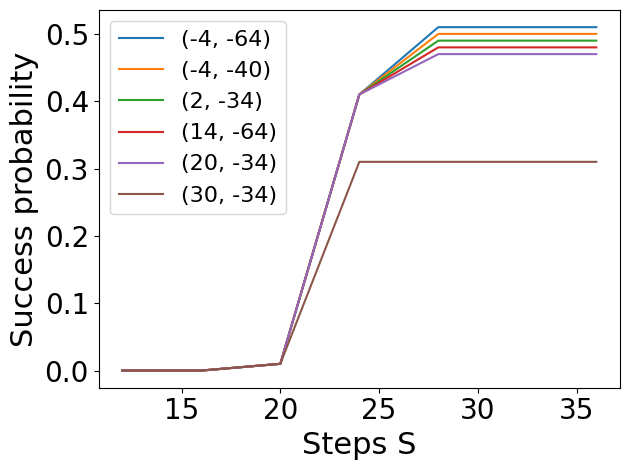

In [37]:
# plot Fig. 1c
file_name = OUTPUT_PATH+"bounded_steps_gas_min_gas_greps.txt"
df_visual = pd.read_csv(file_name)

df_visual_grouped = df_visual.groupby(['m0','m2'])

result_dict = {}
for group in df_visual_grouped.groups.keys():
    r = tuple([round(h,2) for h in df_visual_grouped.get_group(group)['Result'].values])
    if r in result_dict:
        result_dict[r].append(group)
    else:
        result_dict[r] = [group]

for k in result_dict:
    max_m0 = max(h[0] for h in result_dict[k])
    max_m2 = max(h[1] for h in result_dict[k])
    assert((max_m0, max_m2) in result_dict[k])
    if len(set(k)) != 1:
        plt.plot(df_visual_grouped.get_group((max_m0, max_m2))['m1'], k, label = str((max_m0, max_m2)))

plt.legend(fontsize=16)
plt.xlabel("Steps S", fontsize=22)
plt.ylabel("Success probability", fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.savefig("greps/bounded.png", dpi=300)

## Improvement recommendation ranking

In [38]:
query = PrismQuery(g, STORE_PATH, "alergia_reduction_model.prism", PRISM_PATH)
strategy = query.get_strategy(QUERY_PATH+"pos_alergia.props")

skipped ['q37Givefeedback4']
skipped ['q39customerGivefeedback4']
skipped ['q41Taskevent5']
skipped ['q43companyTaskevent5']
skipped ['q62Resultsshared']
skipped ['q63companyResultsshared']


In [44]:
def transform_strategy(strategy, g, printer):
    """ 
    Adjusts the strategy naming from PRISM node naming to original node naming in g
    """
    isomorphism = nx.vf2pp_isomorphism(printer.g, g, node_label=None)
    strategy_isomorphism = {k[len(isomorphism[k].split(": ")[0]):] : ": ".join(isomorphism[k].split(": ")[1:]) for k in isomorphism}
    parsed_strategy = {isomorphism[r] : strategy_isomorphism[strategy[r]] if strategy[r] not in ["env", "user", "company", "do_nothing"] else strategy[r] for r in strategy}
    return parsed_strategy

def lost_users(g, results_file, strategy):
    for s in strategy:
        assert s in g
        next_states = [t for t in g[s] if g[s][t]['action'] == strategy[s]]

        assert(next_states)
        total_lost_users = 0
        for t in next_states:
            action_outcome_cost = len(g[s][t]['trace_indices']) * abs(round(results_file[s],5)-round(results_file[t],5)) #* g[s][t]['prob_weight']
            
            total_lost_users += action_outcome_cost

            if action_outcome_cost!= 0:
                print(len(g[s][t]['trace_indices']), "*", (round(results_file[s],5), round(results_file[t],5)))
                print(action_outcome_cost)
        if total_lost_users != 0:
            print("at", s, "is", strategy[s], "selected")
            print("total", total_lost_users)
            print()

lost_users(g, get_probs_file(results_file, g, printer), transform_strategy(strategy, g, printer))

27 * (0.51515, 0.62963)
3.090960000000001
6 * (0.51515, 0)
3.0909
at q19: Task event: 1 is env selected
total 6.18186

3 * (0.62963, 0)
1.88889
24 * (0.62963, 0.70833)
1.8887999999999998
at q23: Task event: 2 is env selected
total 3.7776899999999998

21 * (0.70833, 0.80952)
2.12499
3 * (0.70833, 0)
2.12499
at q30: Task event: 3 is env selected
total 4.24998

4 * (0.80952, 0)
3.23808
17 * (0.80952, 1.0)
3.2381599999999997
at q49: waitingForActivityReport is env selected
total 6.47624



## GrepS Sankey Diagram

In [40]:
import plotly.graph_objects as go
naming = {
    "q20: companyTask event: 1": "T11",
    "q27: companyTask event: 2": "T13",
    "q31: companyTask event: 3": "T25",
    "q52: customerwaitingForActivityReport" : "unsucc",
    "q51: companywaitingForActivityReport" : "succ",
    "Results shared" : "T26",
    "Logged in: Web page - Approval" : "T26",
    "negative" : "neg",
    "positive" : "pos",
    "q0: start": "T9",
    "finished":"finished"
}

def reduced_sankey_diagram(g, results_file, strategy):
      g = copy.deepcopy(g)
      g = reduce_graph(g, results_file)
      color_map = compute_color_map(g, results_file)


      node_list = list(g.nodes())
      node_dict = {node_list[i] : i for i in range(len(node_list))}
      edge_list = g.edges()
      print(edge_list)
      
      print([len(g[e[0]][e[1]]['trace_indices'])  * abs(round(results_file[e[0]],5)-round(results_file[e[1]],5)) for e in edge_list])
      #print([len(g.edges[e]['trace_indices']) for e in edge_list])
      fig = go.Figure(data=[go.Sankey(
      node = dict(
          pad = 15,
          thickness = 20,
          line = dict(color = "black", width = 0.5),
          label = [naming[str(s)] for s in node_list],
          color = [color_map[s] for s in node_list],
          align = "right"
      ),
      link = dict(
          source = [node_dict[e[0]] for e in edge_list],
          target = [node_dict[e[1]] for e in edge_list],
          value = [len(g[e[0]][e[1]]['trace_indices']) * abs(round(results_file[e[0]],5)-round(results_file[e[1]],5)) for e in edge_list]
          #[len(g.edges[e]['trace_indices']) for e in edge_list]
      ))])
      fig.update_layout(
        font=dict(size = 40)
    )
      fig.write_image("greps/greps_sankey.png")
      fig.show()


reduced_sankey_diagram(g, get_probs_file(results_file, g, printer), strategy)

size start 65
size reduced 6
[('q0: start', 'q20: companyTask event: 1'), ('q0: start', 'q52: customerwaitingForActivityReport'), ('q20: companyTask event: 1', 'q27: companyTask event: 2'), ('q20: companyTask event: 1', 'q52: customerwaitingForActivityReport'), ('q27: companyTask event: 2', 'q31: companyTask event: 3'), ('q27: companyTask event: 2', 'q52: customerwaitingForActivityReport'), ('q31: companyTask event: 3', 'q52: customerwaitingForActivityReport'), ('q31: companyTask event: 3', 'q51: companywaitingForActivityReport'), ('q52: customerwaitingForActivityReport', 'q51: companywaitingForActivityReport'), ('q52: customerwaitingForActivityReport', 'q31: companyTask event: 3'), ('q52: customerwaitingForActivityReport', 'q27: companyTask event: 2'), ('q52: customerwaitingForActivityReport', 'q20: companyTask event: 1')]
[3.090960000000001, 3.0909, 1.8887999999999998, 1.88889, 2.12499, 2.12499, 3.23808, 3.2381599999999997, 0.0, 0.0, 0.0, 0.0]


## Investigate lost users by percentage

In [41]:
print(g.nodes())
total = 0
for e in g.in_edges('q26: negative'):
    total += len(g.edges[e]['trace_indices'])

for e in g.in_edges('q26: negative'):
    print(e, len(g.edges[e]['trace_indices']), len(g.edges[e]['trace_indices'])/total)

['q0: start', 'q2: customerstart', 'q1: companystart', 'q3: vpcAssignInstance', 'q4: registered', 'q5: companyvpcAssignInstance', 'q6: companyregistered', 'q7: vpcCreateUserOnInstance', 'q8: activated', 'q9: companyvpcCreateUserOnInstance', 'q10: companyactivated', 'q11: readyToStart', 'q12: companyreadyToStart', 'q13: started', 'q14: customerstarted', 'q15: Task event: 0', 'q16: companyTask event: 0', 'q17: Give feedback 0', 'q18: customerGive feedback 0', 'q19: Task event: 1', 'q20: companyTask event: 1', 'q25: customerTask event: 1', 'q21: Give feedback 1', 'q22: customerGive feedback 1', 'q23: Task event: 2', 'q24: customerTask event: 2', 'q27: companyTask event: 2', 'q26: negative', 'q28: Give feedback 2', 'q29: customerGive feedback 2', 'q30: Task event: 3', 'q31: companyTask event: 3', 'q32: customerTask event: 3', 'q33: Give feedback 3', 'q34: customerGive feedback 3', 'q35: Task event: 4', 'q36: companyTask event: 4', 'q38: waitingForManualScores', 'q37: Give feedback 4', 'q39

# Sankey Diagram Example

In [42]:
c = ["darkred","gold","darkgreen"]
v = [0,0.5,1]
l = list(zip(v,c))
cmap=LinearSegmentedColormap.from_list('rg',l, N=256)
s = cmap(0.23)
map = {}
for s in [0.35, 0.7, 0, 1]:
    print(s, cmap(s)) # have to convert to hex color


0.35 (0.862637447135717, 0.5885428681276432, 0.0, 1.0)
0.7 (0.596078431372549, 0.6609765474817377, 0.0, 1.0)
0 (0.5450980392156862, 0.0, 0.0, 1.0)
1 (0.5486658977316416, 0.0066128412149173395, 0.0, 1.0)


In [43]:
import plotly.graph_objects as go
label = ["0.35", "0.7", "1", "0"]
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 100,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = label,
      color = [rgb2hex(cmap(float(s))) for s in label]#["#FFD700", "#80AA06", "#054907", "#9A0200"]
    ),
    link = dict(
      source = [0, 0, 1, 1], # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = [3, 1, 3, 2],
      value = [22.5, 22.5, 10.5, 10.5] # for 100 assumed users
  ))])

#fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
fig.update_layout(
    font=dict(size = 50)
)
fig.write_image("out/sankey_example.png")
fig.show()